In [68]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Layer, Lambda, Multiply, Add

# Commonly used modules
import numpy as np
import os
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

print(tf.__version__)

2.4.1


In [3]:
df1 = pd.read_csv("https://raw.githubusercontent.com/VivaswatS/selCoefEst/main/traindata/trip-2021-07-28.csv")

# (train_features, train_labels), (test_features, test_labels) = keras.datasets.boston_housing.load_data()

# # get per-feature statistics (mean, standard deviation) from the training set to normalize by
# train_mean = np.mean(train_features, axis=0)
# train_std = np.std(train_features, axis=0)
# train_features = (train_features - train_mean) / train_std

In [4]:
dat = df1.to_numpy()
gamma = np.unique(dat[:,1])
idx = [np.where(dat[:,1] == gamma[i]) for i in np.arange(len(gamma))]

In [5]:
from sklearn.model_selection import train_test_split
# create an 80/20 split in each data set
temp = [train_test_split(dat[idx[i][0],0], dat[idx[i][0],2], test_size=0.15, random_state=42) for i in np.arange(len(gamma))]

# for each gamma value...
Xltrain = []
Xltest = []
altrain = []
altest = []
for t in np.arange(len(temp)):
    Xltrain.append(temp[t][0])
    Xltest.append(temp[t][1])
    altrain.append(temp[t][2])
    altest.append(temp[t][3])

In [6]:
train_data = np.vstack((np.hstack(Xltrain[0:50]), np.repeat(gamma[0:50], len(Xltrain[0])))).T
train_labs = np.hstack(altrain[0:50])

In [7]:
test_data = np.vstack((np.hstack(Xltest[0:50]), np.repeat(gamma[0:50], len(Xltest[0])))).T
test_labs = np.hstack(altest[0:50])

In [49]:
test_labs.shape

(7500,)

In [98]:
## BaselineNet 
def build_model():
    model = keras.Sequential([
        Dense(50, activation=tf.nn.relu, input_shape=[len(train_data[0])]),
        Dense(10, activation=tf.nn.relu, input_shape=[50]),
        Dense(1)
    ])

    model.compile(optimizer=tf.optimizers.Adam(), 
                  loss='mse',
                  metrics=['mae', 'mse'])
    return model

In [99]:
# this helps makes our output less verbose but still shows progress
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
history = model.fit(train_data, train_labs, epochs=5000, verbose=0, validation_split=0.1,
                    callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


....................................................................................

In [100]:
hist

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,368432064.0,14803.345703,368432064.0,1.142616e+09,29791.412109,1.142616e+09,0
1,239883024.0,11518.271484,239883024.0,5.545529e+08,22242.720703,5.545529e+08,1
2,109053296.0,8333.842773,109053296.0,1.358785e+09,35078.441406,1.358785e+09,2
3,91918368.0,7954.279785,91918368.0,1.436010e+09,36032.757812,1.436010e+09,3
4,88715952.0,7781.286621,88715952.0,1.359189e+09,34974.531250,1.359189e+09,4
...,...,...,...,...,...,...,...
79,38219616.0,4557.788574,38219616.0,2.894413e+07,4461.737305,2.894413e+07,79
80,38202196.0,4556.598145,38202196.0,6.744440e+07,6959.990723,6.744440e+07,80
81,38183152.0,4554.268555,38183152.0,5.652614e+07,6334.424316,5.652614e+07,81
82,38169072.0,4552.724609,38169072.0,8.471372e+07,7844.248535,8.471372e+07,82


In [101]:
rmse_final = np.sqrt(float(hist['val_mse'].tail(1)))
print()
print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_final, 3)))


Final Root Mean Square Error on validation set: 7625.646


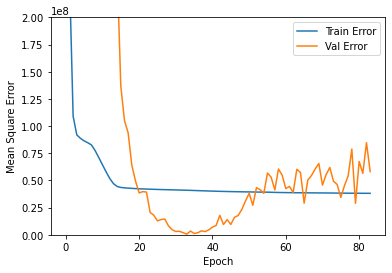

In [104]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.legend()

plot_history()

In [ ]:
#test_features_norm = (test_data - train_mean) / train_std
mse, _, _ = model.evaluate(test_data, test_labs)
rmse = np.sqrt(mse)
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))

7/7 [==============================] - 0s 2ms/step - loss: 19176.2168 - mae: 119.0167 - mse: 19176.2168
Root Mean Square Error on test set: 138.478


In [105]:
preds = model.predict(test_data)
#test_data.shape

In [106]:
np.corrcoef(np.ravel(test_labs), np.ravel(preds))[0,1]

0.8646701780095327

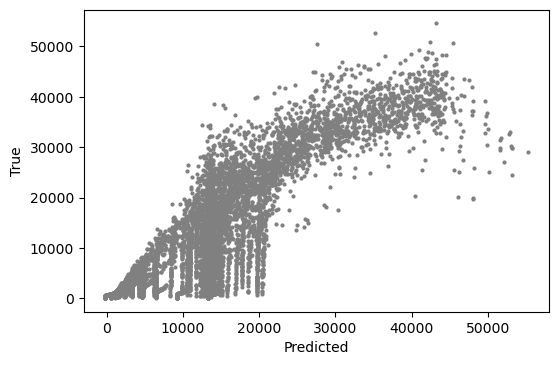

In [107]:
plt.figure(dpi=100)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.plot(np.ravel(preds), np.ravel(test_labs), 'o',  color="grey", markersize=2)

## VAE (similar to architecture above)

Borrowed from https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/

In [78]:
intermediate_dim = 16
latent_dim = 2
batch_size = 512
epsilon_std = 1.0

def mse(y_true, y_pred):
    return keras.backend.sum(keras.metrics.mean_squared_error(y_true, y_pred), axis=-1)

class KLDivergenceLayer(Layer):
    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """
    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):
        mu, log_var = inputs
        kl_batch = - .5 * keras.backend.sum(1 + log_var -
                                            keras.backend.square(mu) -
                                            keras.backend.exp(log_var), axis=-1)

        self.add_loss(keras.backend.mean(kl_batch), inputs=inputs)
        return inputs

# input is 2 dim - (Xl, gamma)
x = keras.Input(shape=(2,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: keras.backend.exp(.5*t))(z_log_var)

eps = keras.Input(tensor=keras.backend.random_normal(stddev=epsilon_std, shape=(keras.backend.shape(x)[0], latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

# only need 1 output dim - allele age
decoder = keras.Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(1, activation='relu')
])

x_pred = decoder(z)

In [109]:
vae = keras.Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=mse)

# vae.fit((train_data, train_data), train_labs,
#         shuffle=True,
#         epochs=50,
#         batch_size=batch_size,
#         validation_data=((test_data, test_data), test_labs))

history = vae.fit((train_data, train_data), train_labs, epochs=5000, verbose=0, validation_split=0.1, shuffle=True,
                    validation_data=((test_data, test_data), test_labs), callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


....................................................................................................
......

In [110]:
hist

,loss,val_loss,epoch
0,285119904.0,51343828.0,0
1,281015808.0,53471344.0,1
2,280003552.0,53703352.0,2
3,279071648.0,55647084.0,3
4,278523776.0,54414588.0,4
...,...,...,...
101,262834448.0,50811340.0,101
102,262683200.0,50917292.0,102
103,263029104.0,50720288.0,103
104,262964000.0,50405564.0,104


In [111]:
# symbolic representation
encoder = keras.Model(x, z_mu)

z_preds = encoder.predict(test_data, batch_size=batch_size)
preds = decoder.predict(z_preds)

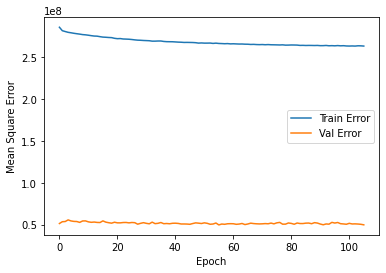

In [112]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['loss'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    plt.legend()

plot_history()

0.809620554750235


Text(0.5, 1.0, 'Allele age estimation')

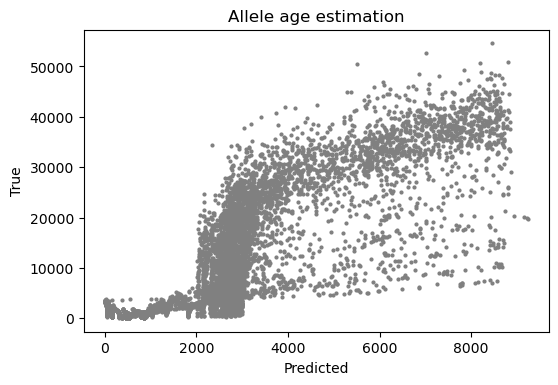

In [113]:
print(np.corrcoef(np.ravel(test_labs), np.ravel(preds))[0,1])
plt.figure(dpi=100)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.plot(np.ravel(preds), np.ravel(test_labs), 'o',  color="grey", markersize=2)
plt.title('Allele age estimation')

In [77]:
?keras.metrics.mean_squared_error

Object `keras.backend.mean_squared_error` not found.


In [46]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [43]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(2))
x = layers.Dense(16, activation="relu")(encoder_inputs)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 16)           48          input_9[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            34          dense_8[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            34          dense_8[0][0]                    
____________________________________________________________________________________________

In [17]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16, activation="relu")(latent_inputs)
decoder_outputs = layers.Dense(1, activation="relu")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________


In [52]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, data, training=False):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data[0])
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(data[1], reconstruction)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [54]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

history = vae.fit(train_data, train_labs, epochs=1000, verbose=0, validation_split=0.1, batch_size=512,
                    callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

ValueError: in user code:

    /usr/local/anaconda3/envs/cvae/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    <ipython-input-52-e260ef82817f>:22 call  *
        z_mean, z_log_var, z = self.encoder(data[0])
    /usr/local/anaconda3/envs/cvae/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__  **
        outputs = call_fn(inputs, *args, **kwargs)
    /usr/local/anaconda3/envs/cvae/lib/python3.9/site-packages/tensorflow/python/keras/engine/functional.py:424 call
        return self._run_internal_graph(
    /usr/local/anaconda3/envs/cvae/lib/python3.9/site-packages/tensorflow/python/keras/engine/functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /usr/local/anaconda3/envs/cvae/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /usr/local/anaconda3/envs/cvae/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:234 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer dense_8 is incompatible with the layer: : expected min_ndim=2, found ndim=1. Full shape received: (2,)


In [18]:
(x_train, y_tr), (x_test, y_te) = keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


(60000,)

## Acknowledgements

The contents of this tutorial is based on and inspired by the work of [TensorFlow team](https://www.tensorflow.org) (see their [Colab notebooks](https://www.tensorflow.org/tutorials/)), our [MIT Human-Centered AI team](https://hcai.mit.edu), and individual pieces referenced in the [MIT Deep Learning](https://deeplearning.mit.edu) course slides.